In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import yaml
import os 
from statsmodels.regression.linear_model import OLS
from statsmodels.iolib.summary2 import summary_col
import numpy as np

In [3]:
base_path = os.getcwd()  
base_path
file_path = os.path.join(base_path, "data/raw/KFFinsurance.csv")
file_path2 = os.path.join(base_path, "data/raw/STATELIFEEST.csv")
file_path3 = os.path.join(base_path, "data/raw/lifeexp.csv")
df = pd.read_csv(file_path, on_bad_lines='skip')
df2 = pd.read_csv(file_path2)
df2.head()
df3 = pd.read_csv(file_path3)
df3.head()
df3 = df3[['state', 'LifeExpectancy', 'LifeExpectancyMale', 'LifeExpectancyFemale']]

     Location  Employer  Non-Group  Medicaid  Medicare  Military  Uninsured  \
0     Alabama     0.463      0.060     0.208     0.163     0.020      0.086   
1      Alaska     0.465      0.049     0.228     0.114     0.037      0.107   
2     Arizona     0.455      0.057     0.208     0.162     0.015      0.103   
3    Arkansas     0.411      0.055     0.274     0.161     0.013      0.085   
4  California     0.470      0.069     0.268     0.120     0.008      0.065   

   Total  Footnotes  
0    1.0        NaN  
1    1.0        NaN  
2    1.0        NaN  
3    1.0        NaN  
4    1.0        NaN  


In [4]:
merged_data_new = pd.merge(df, df2, left_on='Location', right_on='statename', how='inner')
merged_data_new = pd.merge(merged_data_new, df3, left_on='Location', right_on='state', how='inner')
merged_data_new.head()
merged_data_new.to_csv(os.path.join(base_path, "results/df.csv"))


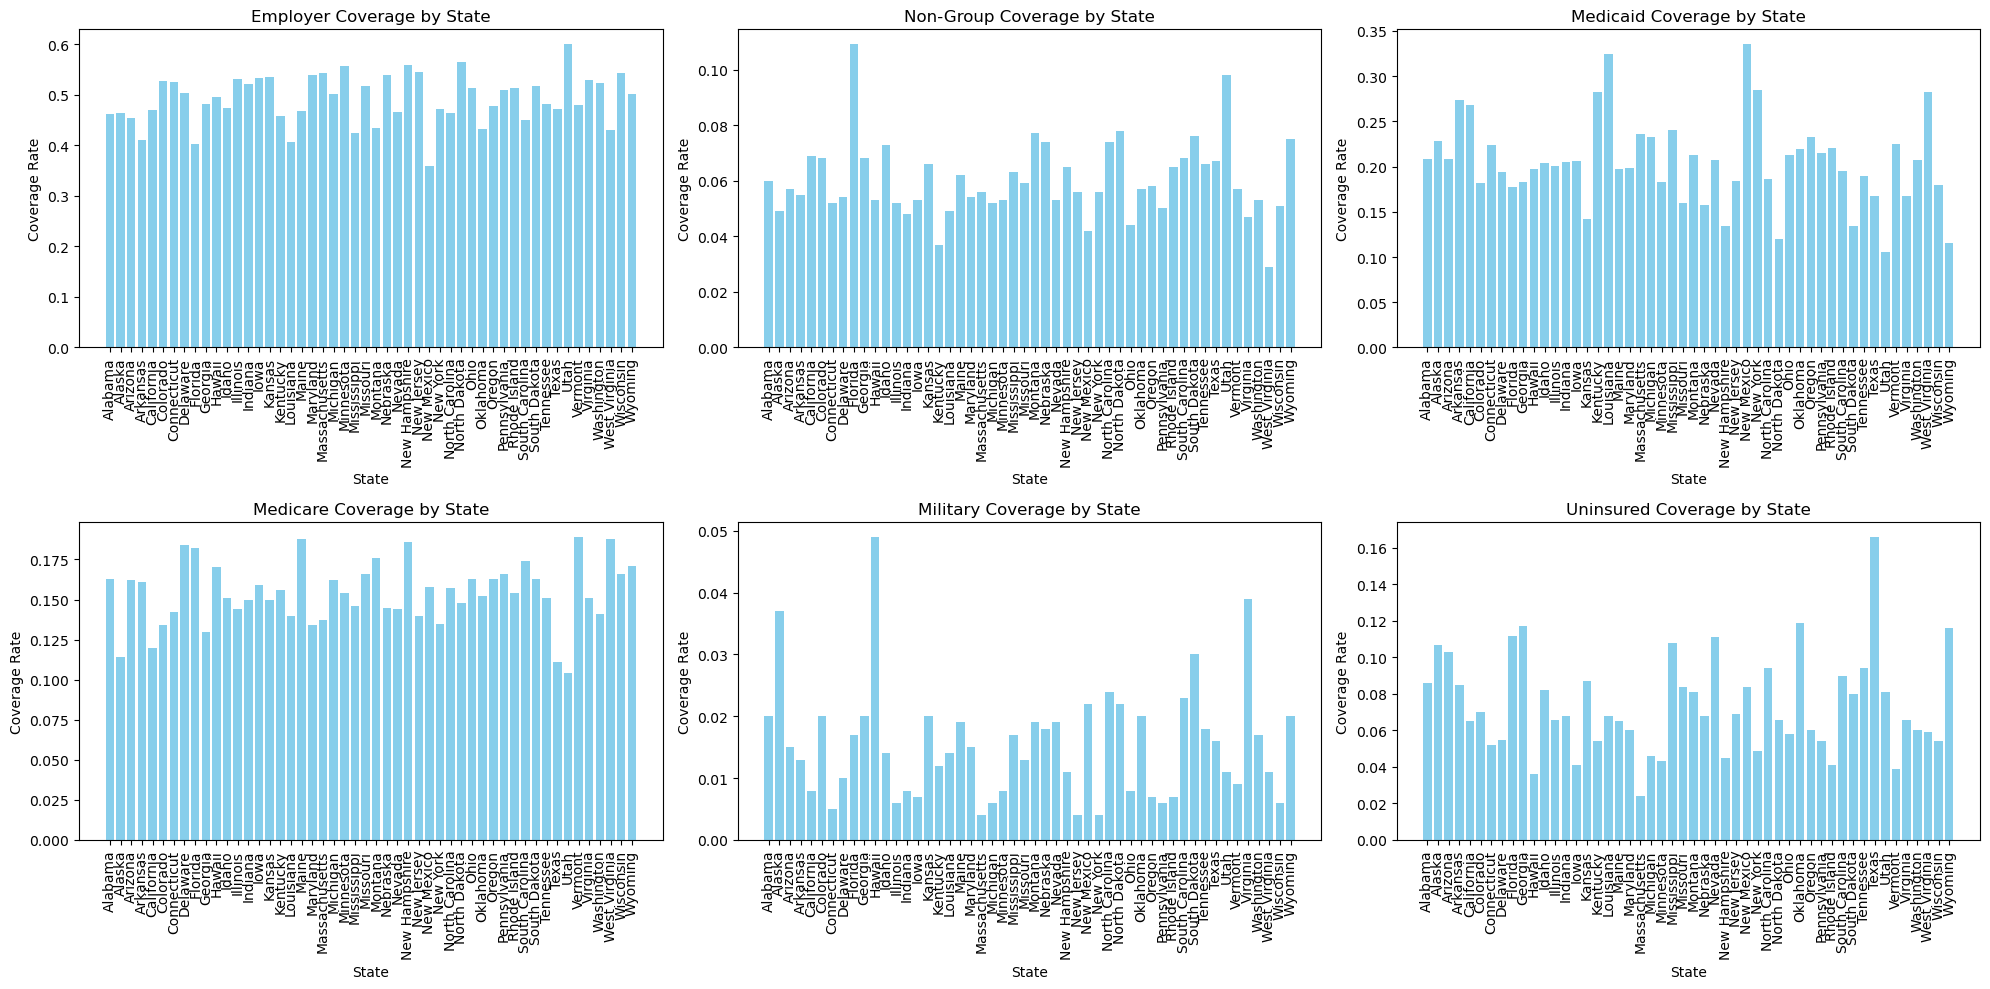

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(20, 10))
coverage_columns = ['Employer', 'Non-Group', 'Medicaid', 'Medicare', 'Military', 'Uninsured']
for i, coverage_type in enumerate(coverage_columns, 1):
    plt.subplot(2, 3, i)
    plt.bar(merged_data_new['Location'], merged_data_new[coverage_type], color='skyblue')
    plt.title(f'{coverage_type} Coverage by State')
    plt.xticks(rotation=90)
    plt.ylabel('Coverage Rate')
    plt.xlabel('State')

plt.tight_layout()
plt.show()
output_file_path = 'results/insurancebar.png'
plt.savefig(output_file_path)

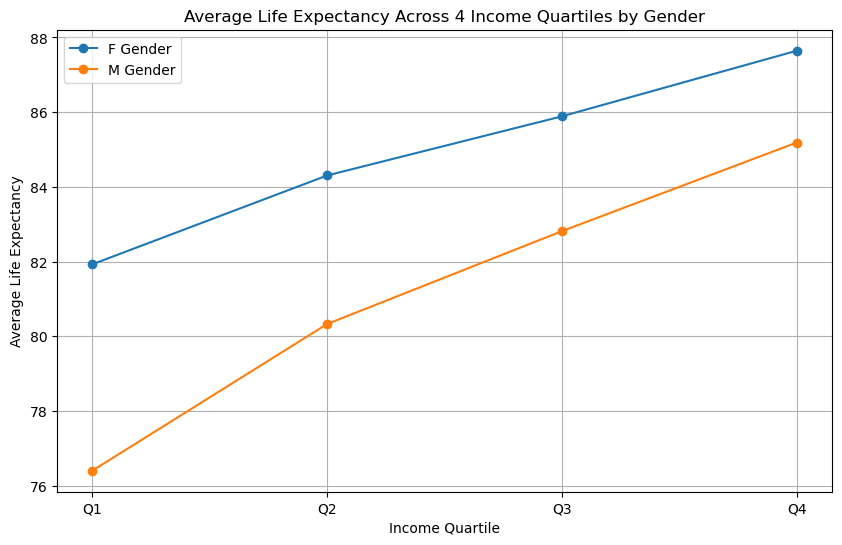

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(10, 6))

quartile_map = {f'Q{i}': i for i in range(1, 5)}

for gender in ['F', 'M']:

    gender_data = []
    for i in range(1, 5):
        gender_data.append(merged_data_new[f'le_agg_q{i}_{gender}'].mean())

    plt.plot(list(quartile_map.values()), gender_data, marker='o', linestyle='-', label=f'{gender} Gender')
plt.title('Average Life Expectancy Across 4 Income Quartiles by Gender')
plt.xlabel('Income Quartile')
plt.ylabel('Average Life Expectancy')
plt.xticks(list(quartile_map.values()), list(quartile_map.keys()))
plt.legend()
plt.grid(True)
plt.show()
output_file_path = 'results/lifeexp.png'
plt.savefig(output_file_path)

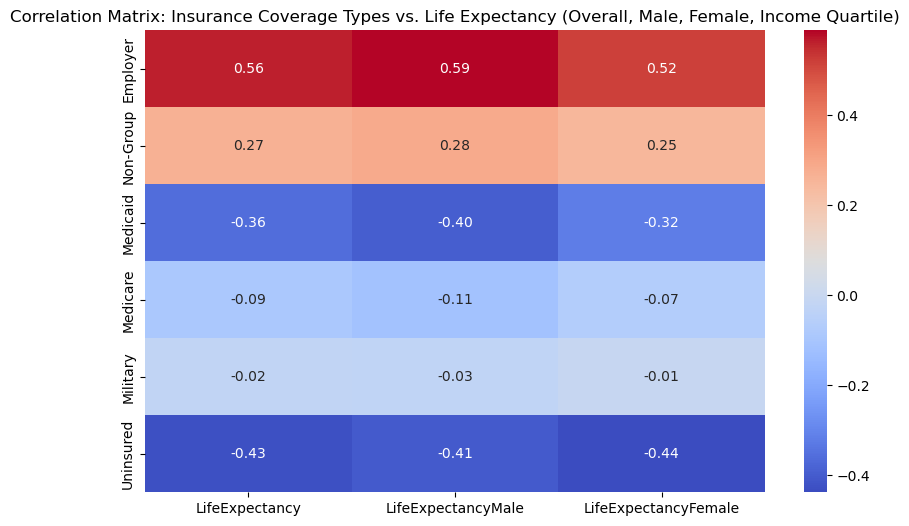

<Figure size 640x480 with 0 Axes>

In [14]:

insurance_columns = ['Employer', 'Non-Group', 'Medicaid', 'Medicare', 'Military', 'Uninsured']
correlation_matrix_life_expectancy = merged_data_new[insurance_columns + ['LifeExpectancy', 'LifeExpectancyMale', 'LifeExpectancyFemale']].corr()
correlation_focus = correlation_matrix_life_expectancy.loc[insurance_columns, ['LifeExpectancy', 'LifeExpectancyMale', 'LifeExpectancyFemale']]
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_focus, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Insurance Coverage Types vs. Life Expectancy (Overall, Male, Female, Income Quartile)')
plt.show()
output_file_path = 'results/corr.png'
plt.savefig(output_file_path)

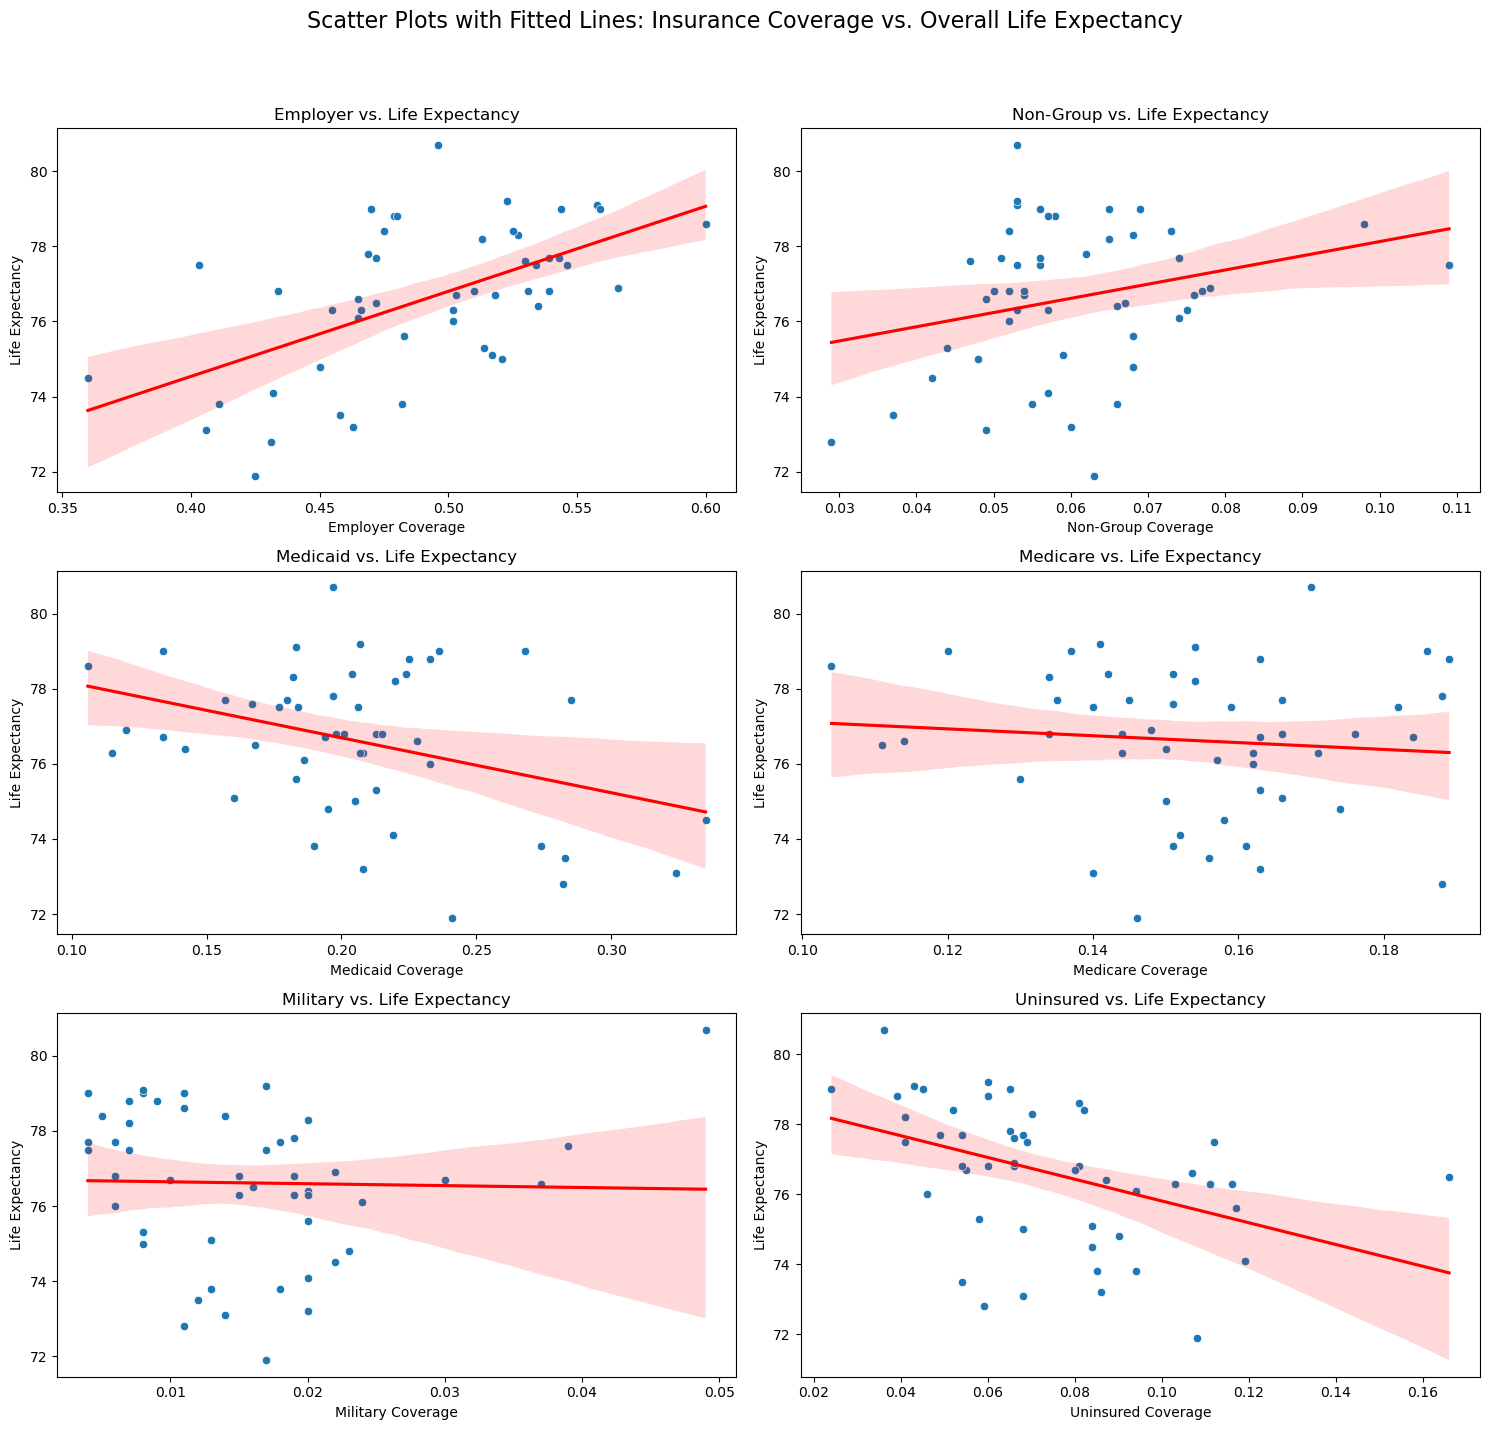

<Figure size 640x480 with 0 Axes>

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
fig.suptitle('Scatter Plots with Fitted Lines: Insurance Coverage vs. Overall Life Expectancy', fontsize=16)
for i, insurance_type in enumerate(insurance_columns):
    sns.scatterplot(x=merged_data_new[insurance_type], y=merged_data_new['LifeExpectancy'], ax=axes[i])
    sns.regplot(x=merged_data_new[insurance_type], y=merged_data_new['LifeExpectancy'], ax=axes[i], scatter=False, color="red")
    axes[i].set_title(f'{insurance_type} vs. Life Expectancy')
    axes[i].set_xlabel(f'{insurance_type} Coverage')
    axes[i].set_ylabel('Life Expectancy')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
output_file_path = 'results/levsic.png'
plt.savefig(output_file_path)

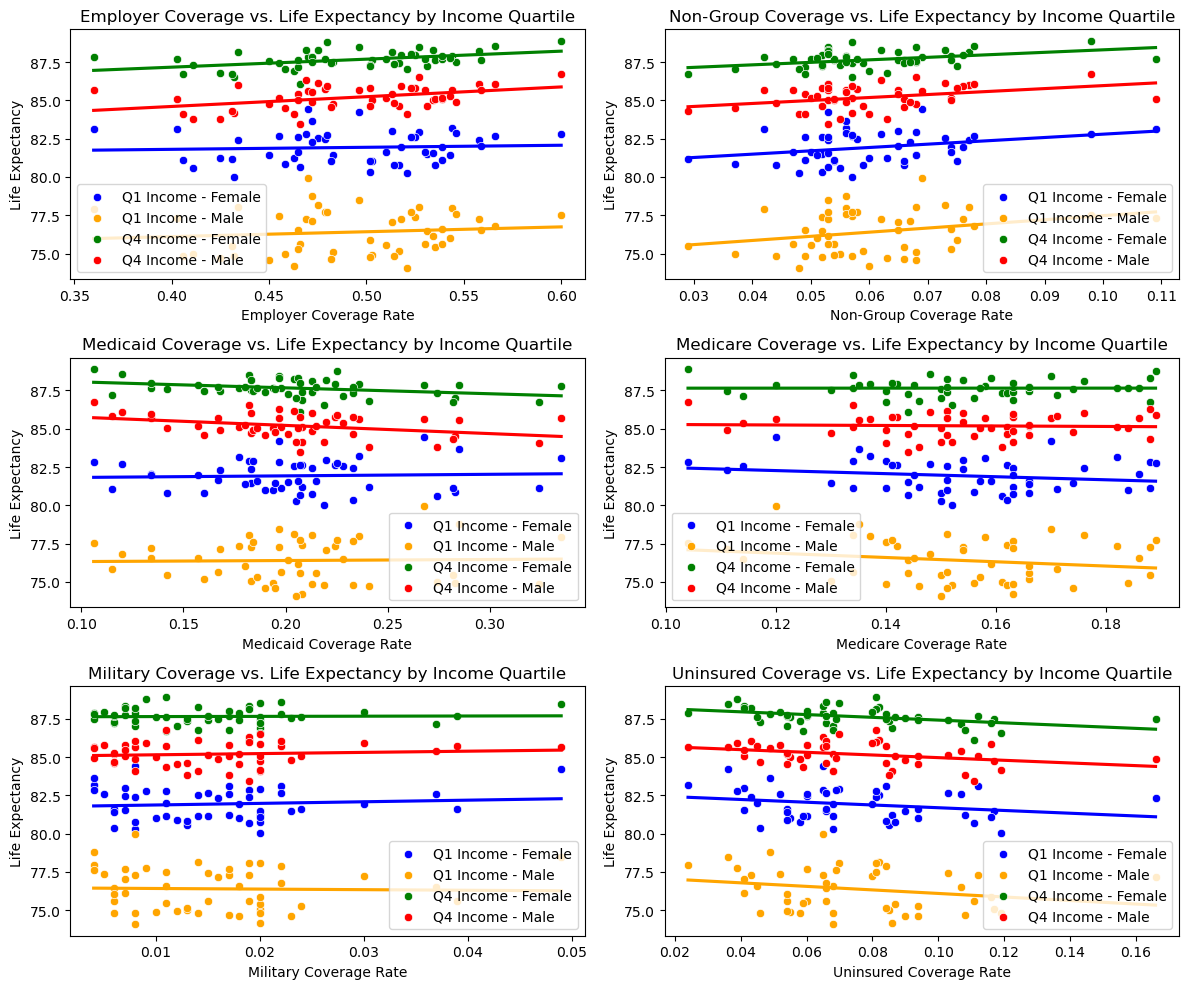

<Figure size 640x480 with 0 Axes>

In [16]:

income_life_exp_columns = ['le_agg_q1_F', 'le_agg_q1_M', 'le_agg_q4_F', 'le_agg_q4_M']

# Create a new DataFrame for plotting
plot_data = merged_data_new[insurance_columns + income_life_exp_columns]

# Now let's create scatter plots with fitted lines for each type of insurance coverage
# against life expectancy for Q1 and Q4 income quartiles.
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # Adjust the size as needed
axes = axes.flatten()

# For each insurance type, plot life expectancy for Q1 and Q4 income quartiles
for i, insurance_type in enumerate(insurance_columns):
    sns.scatterplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q1_F'], color='blue', label='Q1 Income - Female')
    sns.scatterplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q1_M'], color='orange', label='Q1 Income - Male')
    sns.scatterplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q4_F'], color='green', label='Q4 Income - Female')
    sns.scatterplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q4_M'], color='red', label='Q4 Income - Male')
    
    # Add a linear regression fit line for Q1 and Q4 life expectancies for both genders
    sns.regplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q1_F'], scatter=False, color='blue', ci=None)
    sns.regplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q1_M'], scatter=False, color='orange', ci=None)
    sns.regplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q4_F'], scatter=False, color='green', ci=None)
    sns.regplot(ax=axes[i], x=plot_data[insurance_type], y=plot_data['le_agg_q4_M'], scatter=False, color='red', ci=None)
    
    axes[i].set_title(f'{insurance_type} Coverage vs. Life Expectancy by Income Quartile')
    axes[i].set_xlabel(f'{insurance_type} Coverage Rate')
    axes[i].set_ylabel('Life Expectancy')
    axes[i].legend()

plt.tight_layout()
plt.show()
output_file_path = 'results/levsicincomeandgender.png'
plt.savefig(output_file_path)

In [17]:
merged_data_new[insurance_columns] = merged_data_new[insurance_columns] * 100
X = merged_data_new[insurance_columns]
y = merged_data_new['LifeExpectancy']
X = sm.add_constant(X)
models = []
for i in range(1, len(insurance_columns) + 1):
    model = OLS(y, X.iloc[:, :i+1]).fit()
    models.append(model)
X_uninsured = sm.add_constant(merged_data_new[['Uninsured']])
model_uninsured = OLS(y, X_uninsured).fit()
estimation_table1 = summary_col([*models, model_uninsured], stars=True, float_format='%0.2f',
                                       model_names=[*['Model '+str(i+1) for i in range(len(models))], 'Uninsured Only'],
                                       info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                                  'No. observations': lambda x: f"{int(x.nobs)}"})

estimation_table1


,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Uninsured Only
Employer,0.23***,0.22***,0.33***,0.37***,0.50***,-3.02,
,(0.05),(0.05),(0.07),(0.08),(0.09),(3.67),
Medicaid,,,0.18**,0.23**,0.38***,-3.12,
,,,(0.09),(0.09),(0.11),(3.65),
Medicare,,,,0.17,0.26**,-3.29,
,,,,(0.12),(0.12),(3.70),
Military,,,,,0.72**,-2.72,
,,,,,(0.29),(3.59),
Non-Group,,0.29*,0.62***,0.72***,0.94***,-2.55,
,,(0.17),(0.23),(0.24),(0.24),(3.64),


In [157]:
X = merged_data_new[insurance_columns]
y = merged_data_new['le_agg_q1_M']
X = sm.add_constant(X)
models = []
for i in range(1, len(insurance_columns) + 1):
    model = OLS(y, X.iloc[:, :i+1]).fit()
    models.append(model)
X_uninsured = sm.add_constant(merged_data_new[['Uninsured']])
model_uninsured = OLS(y, X_uninsured).fit()
estimation_table2 = summary_col([*models, model_uninsured], stars=True, float_format='%0.2f',
                                       model_names=[*['Model '+str(i+1) for i in range(len(models))], 'Uninsured Only'],
                                       info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                                  'No. observations': lambda x: f"{int(x.nobs)}"})

estimation_table2

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Uninsured Only
Employer,0.03,0.02,0.17***,0.17***,0.25***,-2.76,
,(0.04),(0.04),(0.06),(0.06),(0.07),(3.05),
Medicaid,,,0.24***,0.24***,0.33***,-2.66,
,,,(0.07),(0.07),(0.09),(3.04),
Medicare,,,,0.01,0.06,-2.98,
,,,,(0.10),(0.10),(3.08),
Military,,,,,0.44*,-2.50,
,,,,,(0.24),(2.99),
Non-Group,,0.26*,0.69***,0.69***,0.83***,-2.16,
,,(0.14),(0.18),(0.19),(0.20),(3.03),


In [159]:
X = merged_data_new[insurance_columns]
y = merged_data_new['le_agg_q4_M']
X = sm.add_constant(X)
models = []
for i in range(1, len(insurance_columns) + 1):
    model = OLS(y, X.iloc[:, :i+1]).fit()
    models.append(model)
X_uninsured = sm.add_constant(merged_data_new[['Uninsured']])
model_uninsured = OLS(y, X_uninsured).fit()
estimation_table3 = summary_col([*models, model_uninsured], stars=True, float_format='%0.2f',
                                       model_names=[*['Model '+str(i+1) for i in range(len(models))], 'Uninsured Only'],
                                       info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                                  'No. observations': lambda x: f"{int(x.nobs)}"})

estimation_table3

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Uninsured Only
Employer,0.06***,0.06***,0.09***,0.11***,0.17***,-0.74,
,(0.02),(0.02),(0.03),(0.03),(0.04),(1.49),
Medicaid,,,0.05,0.07*,0.15***,-0.76,
,,,(0.04),(0.04),(0.04),(1.49),
Medicare,,,,0.07,0.11**,-0.81,
,,,,(0.05),(0.05),(1.51),
Military,,,,,0.34***,-0.55,
,,,,,(0.12),(1.46),
Non-Group,,0.17**,0.27***,0.31***,0.41***,-0.49,
,,(0.07),(0.09),(0.10),(0.10),(1.48),


In [132]:
X = merged_data_new[insurance_columns]
y = merged_data_new['le_agg_q1_F']
X = sm.add_constant(X)
models = []
for i in range(1, len(insurance_columns) + 1):
    model = OLS(y, X.iloc[:, :i+1]).fit()
    models.append(model)
X_uninsured = sm.add_constant(merged_data_new[['Uninsured']])
model_uninsured = OLS(y, X_uninsured).fit()
estimation_table3 = summary_col([*models, model_uninsured], stars=True, float_format='%0.2f',
                                       model_names=[*['Model '+str(i+1) for i in range(len(models))], 'Uninsured Only'],
                                       info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                                  'No. observations': lambda x: f"{int(x.nobs)}"})

estimation_table3

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Uninsured Only
Employer,0.01,0.01,0.12***,0.12**,0.21***,-0.94,
,(0.03),(0.03),(0.04),(0.04),(0.05),(2.08),
Medicaid,,,0.18***,0.18***,0.30***,-0.85,
,,,(0.05),(0.05),(0.06),(2.07),
Medicare,,,,0.00,0.07,-1.09,
,,,,(0.07),(0.07),(2.10),
Military,,,,,0.52***,-0.60,
,,,,,(0.16),(2.04),
Non-Group,,0.21**,0.54***,0.54***,0.70***,-0.43,
,,(0.10),(0.13),(0.14),(0.14),(2.07),


In [160]:
X = merged_data_new[insurance_columns]
y = merged_data_new['le_agg_q4_F']
X = sm.add_constant(X)
models = []
for i in range(1, len(insurance_columns) + 1):
    model = OLS(y, X.iloc[:, :i+1]).fit()
    models.append(model)
X_uninsured = sm.add_constant(merged_data_new[['Uninsured']])
model_uninsured = OLS(y, X_uninsured).fit()
estimation_table3 = summary_col([*models, model_uninsured], stars=True, float_format='%0.2f',
                                       model_names=[*['Model '+str(i+1) for i in range(len(models))], 'Uninsured Only'],
                                       info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                                  'No. observations': lambda x: f"{int(x.nobs)}"})

estimation_table3

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Uninsured Only
Employer,0.05***,0.05***,0.09***,0.11***,0.16***,-0.73,
,(0.02),(0.01),(0.02),(0.02),(0.02),(1.00),
Medicaid,,,0.06**,0.09***,0.15***,-0.74,
,,,(0.03),(0.03),(0.03),(0.99),
Medicare,,,,0.08**,0.12***,-0.78,
,,,,(0.04),(0.03),(1.01),
Military,,,,,0.26***,-0.60,
,,,,,(0.08),(0.98),
Non-Group,,0.14***,0.26***,0.31***,0.39***,-0.48,
,,(0.05),(0.07),(0.07),(0.07),(0.99),


In [8]:
sources = {
    "lifeexp.csv.dvc": {
        "description": "life expectancy by state",
        "obtained": "2023-12-08",
        "source": "https://www.cdc.gov/nchs/data/nvsr/nvsr71/nvsr71-02.pdf"
    },
    "KFFinsurance.csv.dvc": {
        "description": "State healthcare insurance coverage",
        "obtained": "2023-12-08",
        "source": "https://www.kff.org/other/state-indicator/health-spending-per-capita/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D"
    },
    "health_ineq_online_table_3.csv.dvc": {
        "description": "State life expectancy by income and gender",
        "obtained": "2023-12-08",
        "source": "https://healthinequality.org/data/",
        "description": "Chetty et al (JAMA 2016) Online Data Tables"
    },
    "health_ineq_online_table_2.csv.dvc": {
        "description": "life expectancy by income and gender",
        "obtained": "2023-12-08",
        "source": "https://healthinequality.org/data/",
        "description": "Chetty et al (JAMA 2016) Online Data Tables"
    },
    "KFFexp.csv.dvc": {
        "description": "State life expectancy by income and gender",
        "obtained": "2023-12-08",
        "source": "data/raw/health_ineq_online_table_2.csv.dvc",
        "description": "Chetty et al (JAMA 2016) Online Data Tables"
    },
    "health_ineq_online_table_1.csv.dvc": {
        "description": " life expectancy by income and gender",
        "obtained": "2023-12-08",
        "source": "https://healthinequality.org/data/",
        "description": "Chetty et al (JAMA 2016) Online Data Tables"
    },
    "STATELIFEEST.csv.dvc": {
        "description": "State life expectancy",
        "obtained": "2023-12-08",
        "source": "https://healthinequality.org/data/",
        "description": "Chetty et al (JAMA 2016) Online Data Tables"
    },
    "health_ineq_online_table_2.csv.dvc": {
        "description": "State life expectancy",
        "obtained": "2023-12-08",
        "source": "https://healthinequality.org/data/",
        "description": "Chetty et al (JAMA 2016) Online Data Tables"
    }
}  
with open('data/raw/source.yaml', 'w') as f:
    yaml.dump(sources, f)